In [122]:
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import folium
from folium.plugins import MarkerCluster
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon, shape
from shapely import ops
import pyproj
import plotly.express as px
from streamlit_folium import st_folium
import plotly.express as px
import streamlit as st 
from plotnine import *

ModuleNotFoundError: No module named 'ggplot'

In [48]:
def cargar_ficheros(fichero):
    if 'zip' in fichero:
        shp_path = fichero

        # Carga el archivo SHP en un GeoDataFrame
        gdf = gpd.read_file(shp_path)
        return gdf
    elif '.json' in fichero:
        with open(fichero, 'r') as file:
            json_data = file.read()
        # Cargar el JSON en un diccionario
        data_dict = json.loads(json_data)
        
        # Obtener la lista 'data' del diccionario
        data_list = data_dict.get('data', [])
        
        # Crear un DataFrame de Pandas con la lista 'data'
        df = pd.DataFrame(data_list)
        return df
    else:
        distritos_table=pd.read_csv('Data\\distritos.csv')
        distritos_table['numero']=distritos_table['numero'].astype(str)
        return distritos_table


df=cargar_ficheros('Data\\response.json')
gdf=cargar_ficheros('Data\\Distritos.zip')
distritos_scrapper=cargar_ficheros('Data\\distritos.csv')

In [49]:
def modificar_col_geometry(df,añadir_geometry_inverted=False):
    if añadir_geometry_inverted:
        df['geometry_inverted'] = df['geometry'].apply(lambda x: Point(x['coordinates'][0],x['coordinates'][1]))
        df['geometry'] = df['geometry'].apply(lambda x: Point(x['coordinates'][1],x['coordinates'][0]))
        df['distrito']=None
    else:
        df['latitud'] = df['geometry'].apply(lambda x: x['coordinates'][1])
        df['longitud'] = df['geometry'].apply(lambda x: x['coordinates'][0])
        df['geometry'] = df['geometry'].apply(lambda x: x['type'])
    return df

In [50]:
def cambio_proyeccion(poly):
    poly_crs = pyproj.CRS("EPSG:25830")
    poly = ops.transform(lambda x, y: pyproj.Transformer.from_crs(poly_crs, pyproj.CRS("EPSG:4326"), always_xy=True).transform(x,y), poly)
    return poly


In [51]:
def estaciones_con_distrito(df,gdf):
    df=modificar_col_geometry(df,True)   
    gdf=gdf.assign(changes=gdf['geometry'])
    gdf['changes']=gdf['changes'].apply(cambio_proyeccion)    
    
    def identificar_distrito(estacion):
        al_reves = gdf['changes'].contains(estacion)
        esta = gdf['NOMBRE'].loc[al_reves]
        return esta.iloc[0] 

    df['distrito']=df['geometry_inverted'].apply(identificar_distrito)
    gdf=gdf.iloc[:, :-1]
    df_con_distrito=df
    return df_con_distrito

In [52]:
def modificar_gdf(gdf,df_estaciones_por_distrito):
    gdf_con_estaciones=gdf.merge(df_estaciones_por_distrito,left_on='NOMBRE', right_on='distrito',how='left')
    gdf_con_estaciones['COD_DIS_TX']=gdf_con_estaciones['count']
    gdf_con_estaciones=gdf_con_estaciones.iloc[:, :-2]
    gdf_con_estaciones = gdf_con_estaciones.rename(columns={'COD_DIS_TX': 'Estaciones'})
    return gdf_con_estaciones

In [53]:
df_distrito=estaciones_con_distrito(df,gdf)

In [54]:
bicis_distrito=df_distrito.groupby('distrito')[['distrito','total_bases']].sum('total_bases').reset_index().rename(columns={'total_bases': 'count'})

In [55]:
gdf_con_estaciones=modificar_gdf(gdf,bicis_distrito)

In [56]:
gdf_distritos=gdf_con_estaciones.rename(columns={'Estaciones': 'bicis'})[['COD_DIS','bicis','NOMBRE']]

In [57]:
gdf_distritos

,COD_DIS,bicis,NOMBRE
0,1,1395,Centro
1,10,740,Latina
2,11,822,Carabanchel
3,12,396,Usera
4,13,608,Puente de Vallecas
5,14,255,Moratalaz
6,15,735,Ciudad Lineal
7,16,740,Hortaleza
8,17,436,Villaverde
9,18,453,Villa de Vallecas


In [58]:
distritos_scrapper

,numero,nombre,area,poblacion,densidad
0,1,Centro,522.82,131928.0,252.34
1,2,Arganzuela,646.22,151965.0,235.16
2,3,Retiro,546.62,118516.0,216.82
3,4,Salamanca,539.24,143800.0,266.67
4,5,Chamartín,917.55,143422.0,156.31
5,6,Tetuán,537.47,153789.0,286.13
6,7,Chamberí,467.92,137401.0,293.64
7,8,Fuencarral-El Pardo,23783.84,238756.0,10.04
8,9,Moncloa-Aravaca,4653.11,116903.0,25.12
9,10,Latina,2542.72,233808.0,91.95


In [59]:
df_con_scrapper=distritos_scrapper.merge(gdf_distritos, left_on='numero', right_on='COD_DIS')[['nombre','area','poblacion','densidad','bicis']]

¿Cual es el distrito con más bicis por persona?¿Y el que menos?

¿Cual es el distrito con mas bicis por metro cuadrado?¿Y el que menos?

In [60]:
df_con_scrapper['personas por bici']=df_con_scrapper['poblacion']/df_con_scrapper['bicis']

In [61]:
df_con_scrapper.sort_values(by='personas por bici').head(5)

,nombre,area,poblacion,densidad,bicis,personas por bici
0,Centro,522.82,131928.0,252.34,1395,94.572043
20,Barajas,4192.28,46876.0,11.18,393,119.277354
3,Salamanca,539.24,143800.0,266.67,989,145.399393
8,Moncloa-Aravaca,4653.11,116903.0,25.12,778,150.260925
1,Arganzuela,646.22,151965.0,235.16,935,162.529412


In [142]:
fig = px.bar(df_con_scrapper, y='personas por bici', x='nombre', 
             labels={'nombre': 'Distrito', 'area': 'Personas por Bici'},
             color_discrete_sequence=['#4682B4'])

fig.update_xaxes(tickangle=20, tickmode='array')
fig.update_xaxes(title_standoff=20)
# Poner el nombre del eje x en negrita
fig.update_xaxes(title_text='Distritos', title_font=dict(size=20, family='Arial', color='black'))

# Poner el nombre del eje y en negrita
fig.update_yaxes(title_text='Personas por Bici', title_font=dict(size=20, family='Arial', color='black'))

In [109]:
df_con_scrapper['hectareas por bici']=(df_con_scrapper['area']*100)/df_con_scrapper['bicis']

In [145]:
df_con_scrapper['hectareas']=df_con_scrapper['area']*100

fig = px.bar(df_con_scrapper, y='hectareas', x='nombre', 
             labels={'nombre': 'Distrito', 'hectareas': 'Hectareas'},
             color_discrete_sequence=['#4682B4'])

fig.update_xaxes(tickangle=20, tickmode='array')
fig.update_xaxes(title_standoff=20)
# Poner el nombre del eje x en negrita
fig.update_xaxes(title_text='Distritos', title_font=dict(size=20, family='Arial', color='black'))

# Poner el nombre del eje y en negrita
fig.update_yaxes(title_text='Hectáreas', title_font=dict(size=20, family='Arial', color='black'))

In [137]:
fig = px.bar(df_con_scrapper, y='hectareas por bici', x='nombre', 
             labels={'nombre': 'Distrito', 'hectareas por bici': 'hectareas por bici'},
             color_discrete_sequence=['#4682B4'])

    # Puedes ajustar el ángulo del texto del eje x
fig.update_xaxes(tickangle=20, tickmode='array')
fig.update_xaxes(title_standoff=20)
# Poner el nombre del eje x en negrita
fig.update_xaxes(title_text='Distritos', title_font=dict(size=20, family='Arial', color='black'))

# Poner el nombre del eje y en negrita
fig.update_yaxes(title_text='Hectáreas por Bici', title_font=dict(size=20, family='Arial', color='black'))


In [63]:
df_con_scrapper.sort_values(by='hectareas por bici')

,nombre,area,poblacion,densidad,bicis,personas por bici,hectareas por bici
0,Centro,522.82,131928.0,252.34,1395,94.572043,37.478136
3,Salamanca,539.24,143800.0,266.67,989,145.399393,54.523761
6,Chamberí,467.92,137401.0,293.64,700,196.287143,66.845714
1,Arganzuela,646.22,151965.0,235.16,935,162.529412,69.114439
2,Retiro,546.62,118516.0,216.82,701,169.067047,77.977175
5,Tetuán,537.47,153789.0,286.13,533,288.534709,100.838649
4,Chamartín,917.55,143422.0,156.31,832,172.382212,110.282452
14,Ciudad Lineal,1142.57,212529.0,186.01,735,289.155102,155.451701
10,Carabanchel,1404.83,243998.0,173.68,822,296.834550,170.903893
11,Usera,777.77,134791.0,173.30,396,340.381313,196.406566


TypeError: 'module' object is not callable

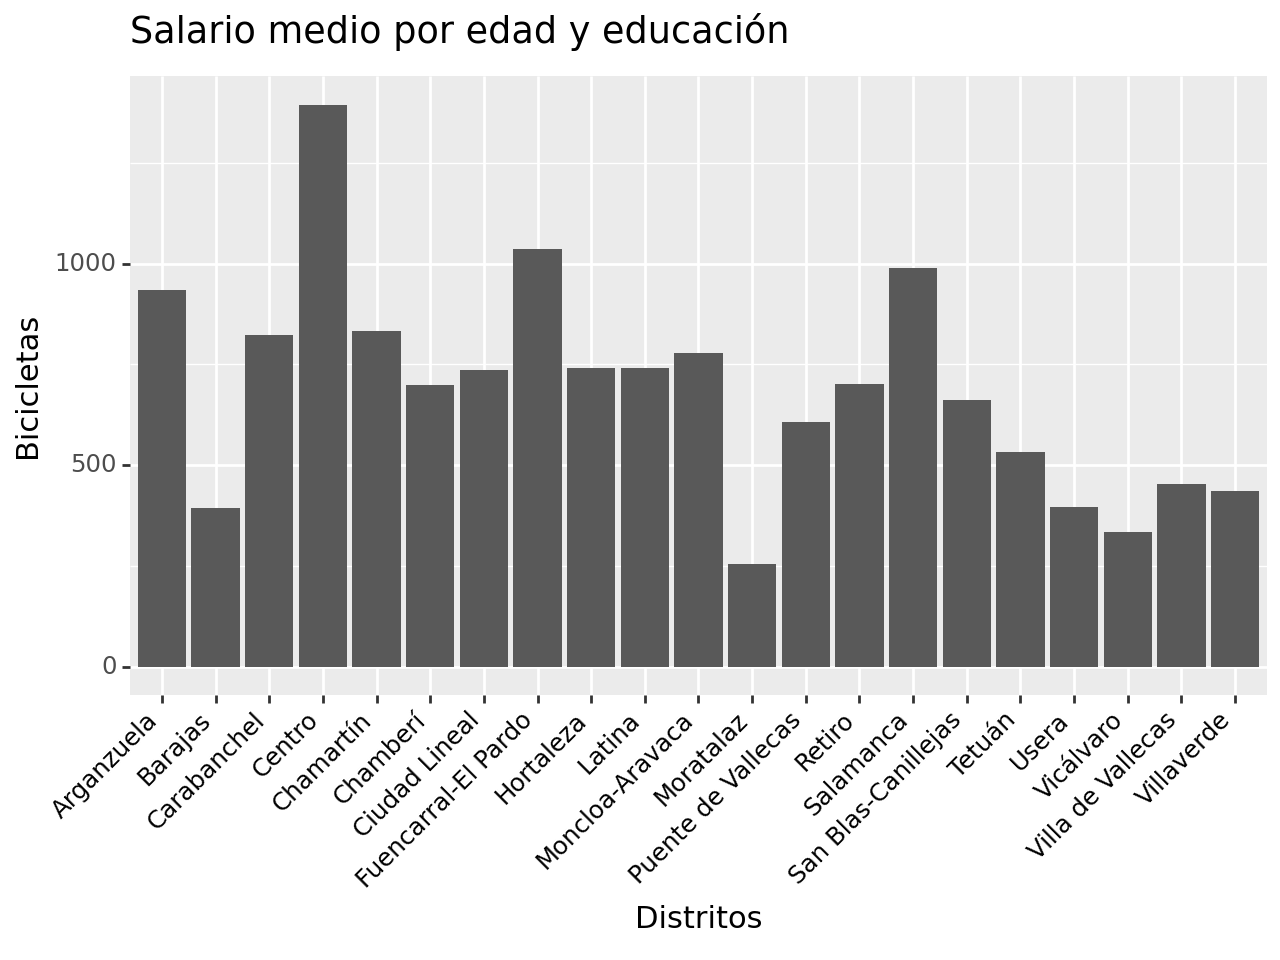

<Figure Size: (640 x 480)>

In [66]:
from plotnine import ggplot, aes, geom_bar, scale_x_discrete, scale_y_discrete,scale_y_continuous, theme, element_text, ggtitle, element_blank, element_blank, labs

(
ggplot(df_con_scrapper, aes(x='nombre',y='bicis'))+
    geom_bar(stat="identity")+
    labs(y = "Bicicletas", x='Distritos')+
    ggtitle('Salario medio por edad y educación')+
    theme(axis_text_x = element_text(angle = 45, hjust = 1,color = "black"))


)

In [148]:
from plotnine import ggplot, aes, geom_bar, scale_x_discrete, scale_y_discrete,scale_y_continuous, theme, element_text, ggtitle, element_blank, element_blank, labs

(
ggplot(df_con_scrapper, aes(x='nombre',y='bicis'))+
    geom_bar(stat="identity")+
    labs(y = "Bicicletas", x='Distritos')+
    ggtitle('Salario medio por edad y educación')+
    theme(axis_text_x = element_text(angle = 45, hjust = 1,color = "black"))


)

ImportError: cannot import name 'gg2mpl' from 'plotnine' (C:\Users\alexb\anaconda3\Lib\site-packages\plotnine\__init__.py)

In [68]:
df_distrito

,activate,address,dock_bikes,free_bases,geometry,id,light,name,no_available,number,reservations_count,total_bases,virtualDelete,geofenced_capacity,geometry_inverted,distrito
0,1,"Avenida del Ensanche de Vallecas, 9,",9,18,POINT (40.37043968 -3.61253028),2190,2,"453 - Avenida del Ensanche de Vallecas, 9",0,453,0,27,False,20,POINT (-3.61253028 40.37043968),Villa de Vallecas
1,1,"Paseo de la Chopera,33,Comunidad de Madrid España",20,3,POINT (40.39500000000003 -3.700399664723875),2205,1,"267 - Paseo de la Chopera, 33",0,267,0,23,False,20,POINT (-3.700399664723875 40.39500000000003),Arganzuela
2,1,"Paseo de la Castellana nº 164,Comunidad de Mad...",3,20,POINT (40.4591366 -3.6894151),2225,0,157 - Castellana 164.,0,157,0,23,False,20,POINT (-3.6894151 40.4591366),Chamartín
3,1,"Guetaria , 84b,",12,12,POINT (40.36916772 -3.71569102),2226,2,395b - 395 - Guetaria 84b,0,395b,0,24,False,20,POINT (-3.71569102 40.36916772),Usera
4,1,"Calle de Gloria Fuertes, 181,",10,17,POINT (40.4956969 -3.7249527),2151,2,"592 - Calle de Gloria Fuertes, 181",0,592,0,27,False,20,POINT (-3.7249527 40.4956969),Fuencarral - El Pardo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
604,1,"Calle León Gil de Palacio nº 3,",18,6,POINT (40.4029202 -3.6788343),1584,1,178 - Junta Municipal Retiro,0,178,0,24,False,20,POINT (-3.6788343 40.4029202),Retiro
605,1,"Calle San Modesto, 42,",4,20,POINT (40.4858012 -3.6923396),2312,0,"598 - Calle San Modesto, 42",0,598,0,24,False,20,POINT (-3.6923396 40.4858012),Fuencarral - El Pardo
606,1,"Calle San Restituto, 74,",16,7,POINT (40.46588016 -3.71693008),2084,2,"307 - Calle San Restituto, 74",0,307,0,23,False,20,POINT (-3.71693008 40.46588016),Moncloa - Aravaca
607,1,"Calle Serrano Galvache,",2,21,POINT (40.471382 -3.6679379),2021,0,486 - Calle Serrano Galvache,0,486,0,23,False,20,POINT (-3.6679379 40.471382),Ciudad Lineal


In [69]:
from plotnine import ggplot, aes, geom_dotplot, labs,geom_boxplot,geom_density, facet_wrap

(ggplot(df_distrito, aes(x='total_bases', y=1, fill='distrito')) + 
    geom_dotplot(stackgroups=True, method='histodot', binwidth=0.1) + 
    labs(title='Dotplot de Ratings por Temporada')
).save(filename='dotplot_ratings.png', format='png')

C:\Users\alexb\anaconda3\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
C:\Users\alexb\anaconda3\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: dotplot_ratings.png


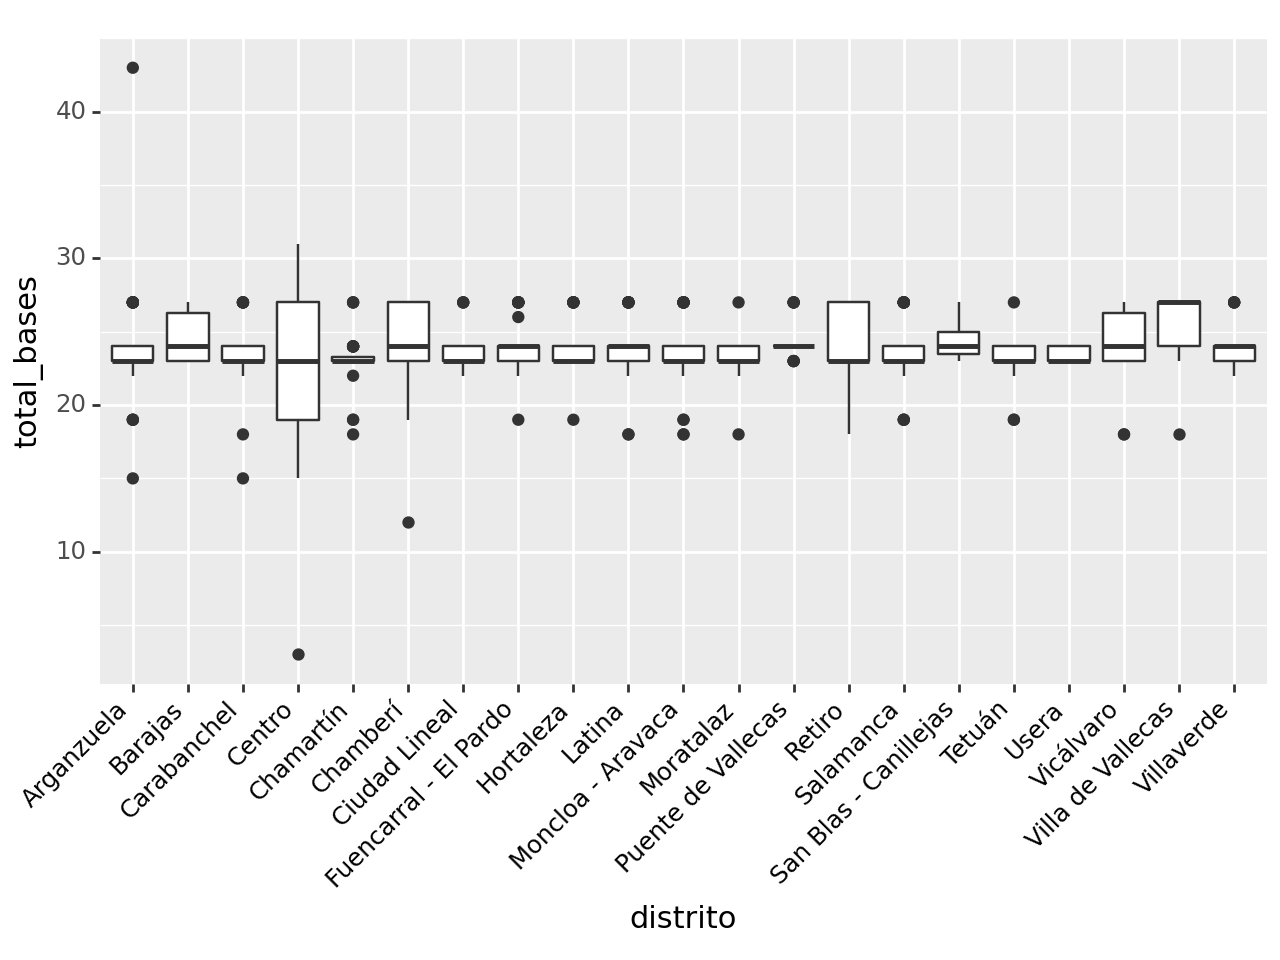

<Figure Size: (640 x 480)>

In [70]:
(ggplot(df_distrito, aes(x = 'distrito', y = 'total_bases')) +
  geom_boxplot()+
  theme(axis_text_x = element_text(angle = 45, hjust = 1,color = "black"))

)

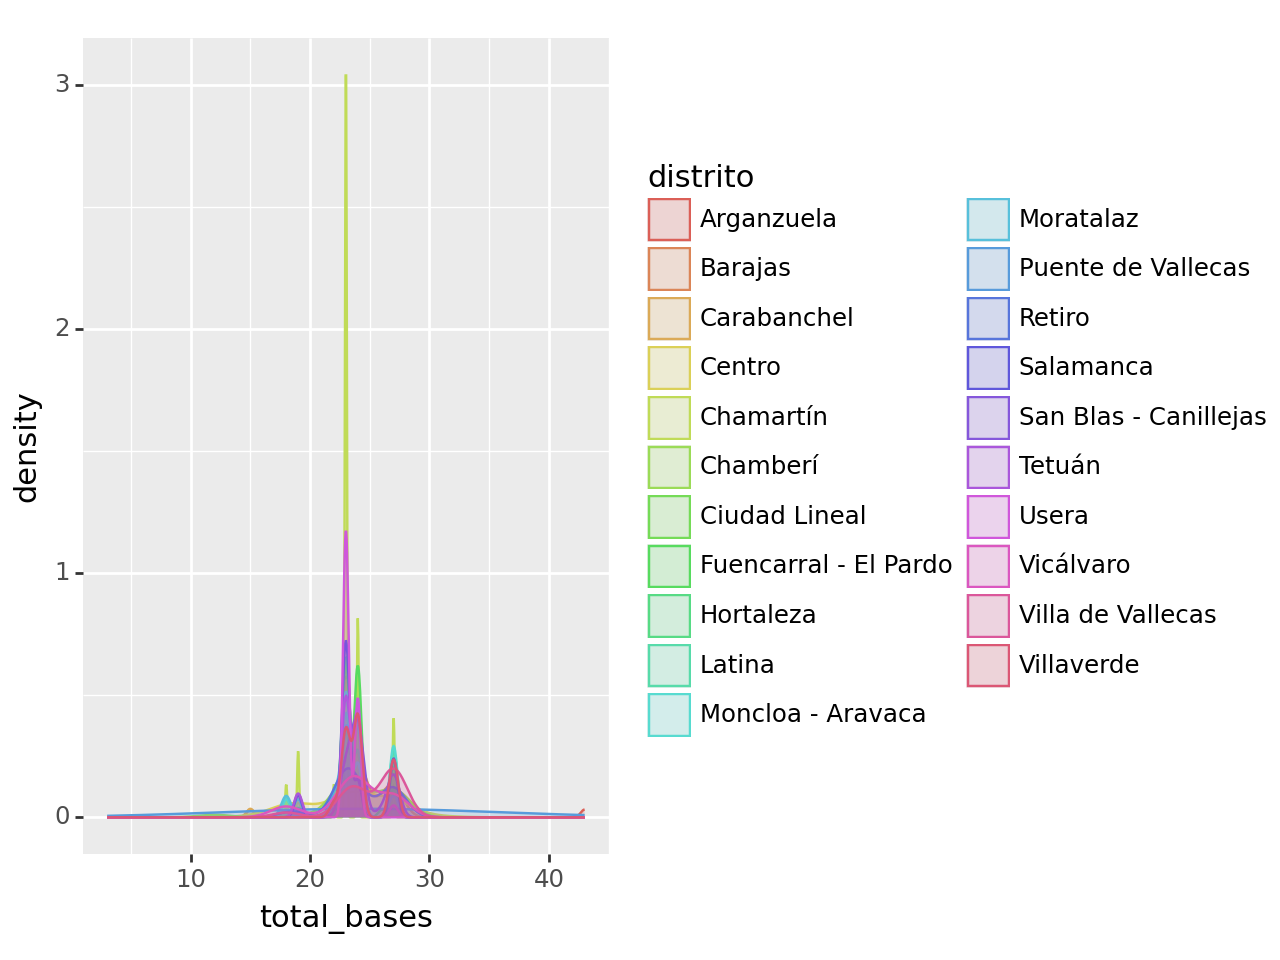

<Figure Size: (640 x 480)>

In [71]:
(ggplot(df_distrito, aes(x='total_bases', fill='distrito')) + 
  geom_density(aes(color='distrito'), alpha=0.2)#+
  #facet_wrap('~distrito')

)

In [90]:
df_distrito['distrito'].unique()

array(['Villa de Vallecas', 'Arganzuela', 'Chamartín', 'Usera',
       'Fuencarral - El Pardo', 'Carabanchel', 'Hortaleza', 'Latina',
       'San Blas - Canillejas', 'Ciudad Lineal', 'Moncloa - Aravaca',
       'Centro', 'Retiro', 'Salamanca', 'Tetuán', 'Villaverde',
       'Puente de Vallecas', 'Vicálvaro', 'Barajas', 'Chamberí',
       'Moratalaz'], dtype=object)

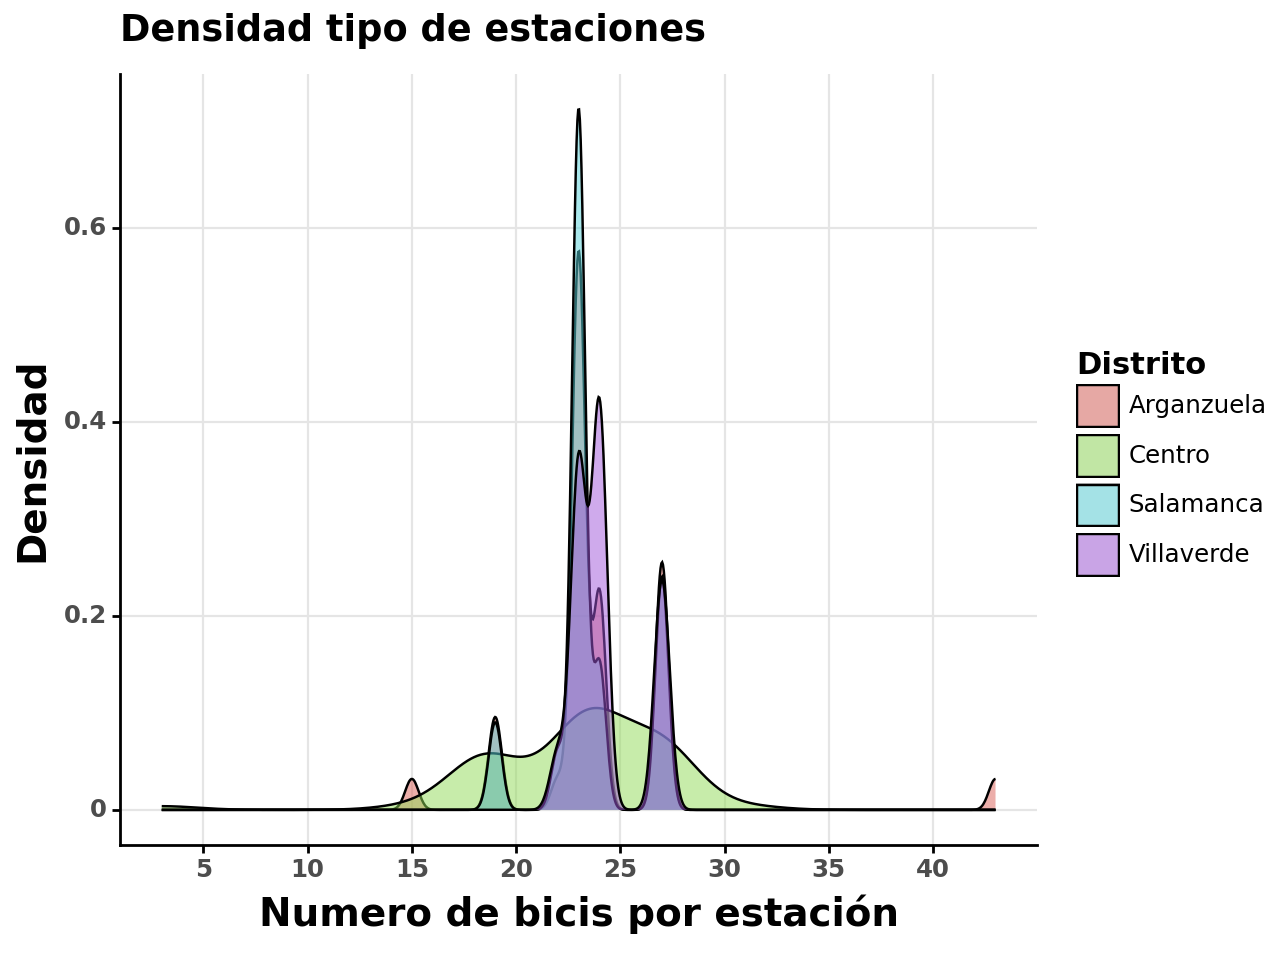

<Figure Size: (640 x 480)>

In [151]:
def dame_densidad_tamaño_estacion(df_distrito,distrito):
    df_distrito=df_distrito.rename(columns={'distrito': 'Distrito'})
    return (ggplot(df_distrito.loc[df_distrito['Distrito'].isin(distrito)], aes(x='total_bases', fill='Distrito')) + 
      geom_density(alpha=0.5)+
      scale_x_continuous(breaks=range(0, 41, 5), minor_breaks=[])+
      scale_y_continuous(minor_breaks=[])+
      theme_bw()+
      theme(legend_title=element_text(weight='bold'),
            axis_text=element_text(weight='bold'),
           plot_title = element_text(color = "black", face="bold"),
           axis_title = element_text(size = 14, color = "black", face="bold"),
           panel_background = element_blank(),
           axis_line = element_line(color = "black", size=1),
           axis_ticks = element_line(color = "black", size=1))+
      labs(x='Numero de bicis por estación', y='Densidad', title='Densidad tipo de estaciones', color='Distritos')
    )
dame_densidad_tamaño_estacion(df_distrito,['Centro','Arganzuela','Salamanca','Villaverde'])

In [24]:
hola=df_distrito.groupby(['distrito','light']).count().reset_index()[['distrito','light','number']]

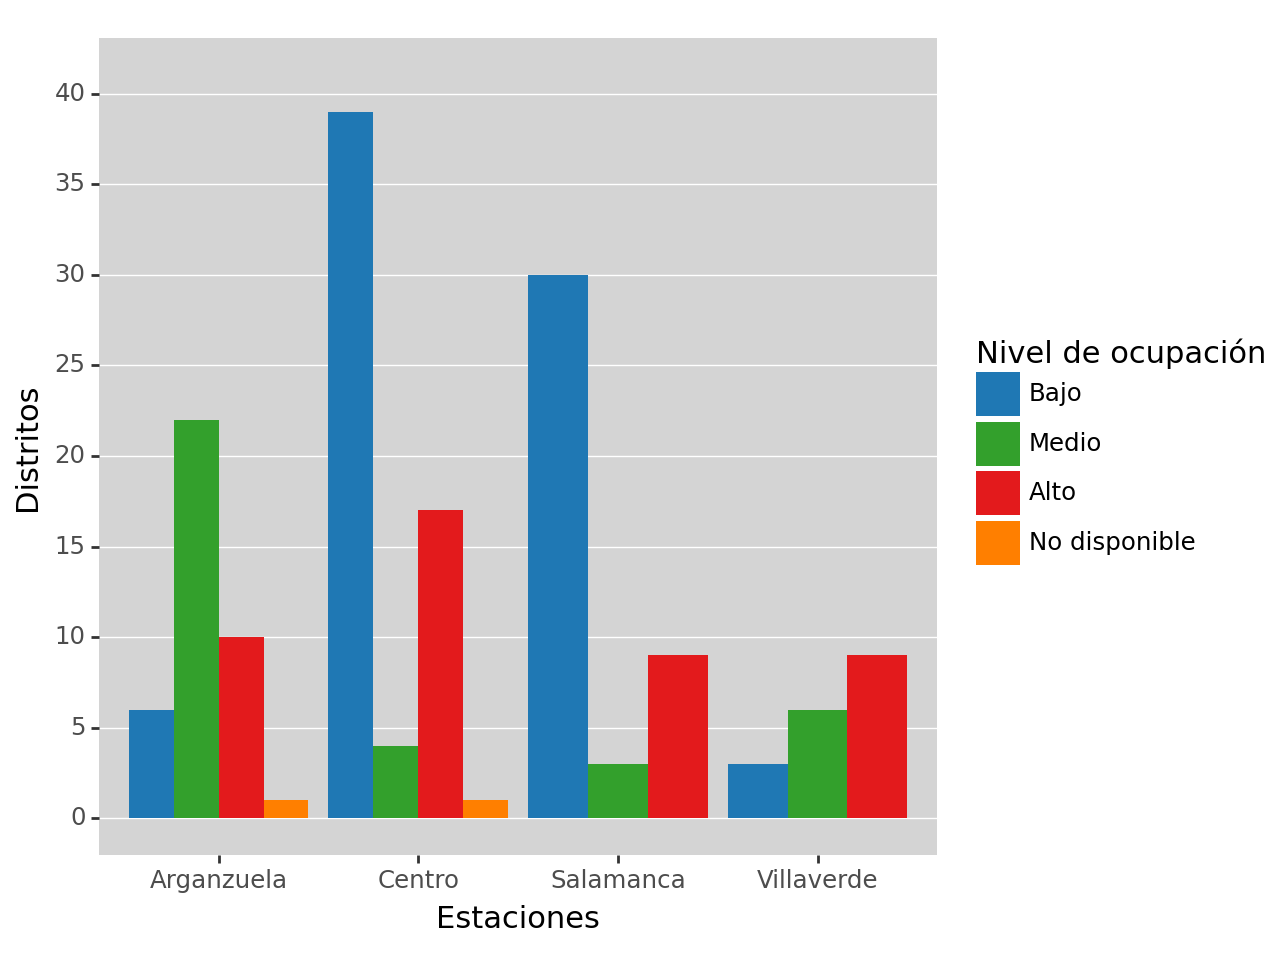

<Figure Size: (640 x 480)>

In [152]:
from plotnine import ggplot, aes, geom_dotplot, labs,geom_boxplot,geom_density, facet_wrap,scale_fill_manual

def dame_luz(df_distrito,distrito, formato='dodge'):
    return (ggplot(df_distrito.loc[df_distrito['distrito'].isin(distrito)], aes(x='distrito', fill='factor(light)')) + 
    geom_bar(position=formato) + 
    scale_fill_manual(values=["#1f78b4", "#33a02c", "#e31a1c", "#ff7f00"],name = "Nivel de ocupación",labels = ['Bajo','Medio','Alto','No disponible'])+
    theme(panel_grid_major_x=element_blank(),
          panel_background=element_rect(fill='#d4d4d4'),
          panel_grid_major_y=element_line(size=0.5))+
    scale_y_continuous(breaks=range(0, 41, 5),
                       minor_breaks=range(0, 41, 5))+
    labs(x='Estaciones', y='Distritos')+
    expand_limits(y=(0, 41))
)#.save(filename='dotplot_ratings.png', format='png')
dame_luz(df_distrito,['Centro','Arganzuela','Salamanca','Villaverde'])

Cual es la estacion en porcentaje con más estaciones con nivel de ocupacion bajo

In [187]:
low=df_distrito.loc[df_distrito['light']==0]['distrito'].value_counts().reset_index().rename(columns={'count': 'light'})
result=(df_distrito['distrito'].value_counts().reset_index()).merge(low,on='distrito')
result['porcentaje']=result['light']/result['count']
result.loc[result['porcentaje']==result['porcentaje'].max()][['distrito','porcentaje']].iloc[0, 0]

'Chamartín'

In [164]:
result

,distrito,count_x,count_y
0,Centro,61,39
1,Fuencarral - El Pardo,43,13
2,Salamanca,42,30
3,Arganzuela,39,6
4,Chamartín,36,28
5,Carabanchel,35,8
6,Moncloa - Aravaca,33,13
7,Hortaleza,31,13
8,Latina,31,7
9,Ciudad Lineal,31,11


In [9]:
def num_estaciones_por_distrito(df_con_distrito):
    df_estaciones_por_distrito=df_con_distrito['distrito'].value_counts().reset_index()
    return df_estaciones_por_distrito

In [10]:
df_estaciones_por_distrito=num_estaciones_por_distrito(df_con_distrito)

NameError: name 'df_con_distrito' is not defined

In [192]:
hola='Ocupacion baja'
hola.split(' ')[1][:0]

''

In [ ]:

df_estaciones_por_distrito = df_estaciones_por_distrito.rename(columns={'Count': 'Cantidad_estaciones'})

In [178]:
def distrito_nivel_ocupacion(df_distrito,opcion,filtro=0):    
    low=df_distrito.loc[df_distrito['light']==filtro]['distrito'].value_counts().reset_index().rename(columns={'count': 'light'})
    result=(df_distrito['distrito'].value_counts().reset_index()).merge(low,on='distrito')
    result['porcentaje']=result['light']/result['count']
    if opcion=='max':
        return result.loc[result['porcentaje']==result['porcentaje'].max()][['distrito','porcentaje']]
    else:
        return result.loc[result['porcentaje']==result['porcentaje'].min()][['distrito','porcentaje']]